In [1]:
import os
from pathlib import Path
from math import ceil

import numpy as np
import pandas as pd
import sympy as sp
from sympy import symbols as s
from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from lab_tools import lab_round

%matplotlib widget

graph_path = Path("../images/").resolve()
table_path = Path("../tables/").resolve()
data_path = Path("../data/").resolve()

plt.style.use("./report.mplstyle")

Variabili

In [2]:
wave_length = 650 / 10**9

slit_name = 0.08
slit = slit_name / 10**3
slit_pos = 4 / 10**2

sensor_name = 1.5
sensor = sensor_name / 10**3
sensor_pos = 102.5 / 10**2

distance = sensor_pos - slit_pos

Load data

In [3]:
dfs = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(sensor_name) in file
]
print(len(dfs))

# Scelti mettendo lo 0 a metà tra i primi minimi
dfs[0].y += 0.098
dfs[1].y += 0.0962
dfs[2].y += 0.0982

3


Center sets on 0

(-0.7396965010000001, 16.252010341)

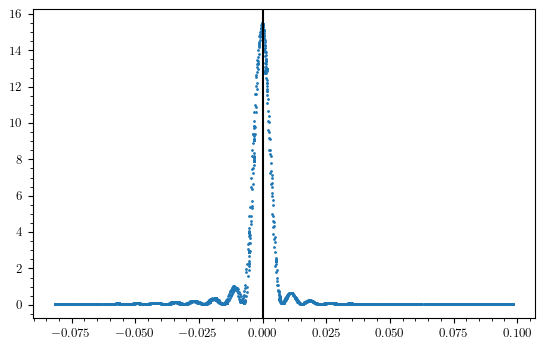

In [4]:
fig, ax = plt.subplots(1, 1)

df = dfs[0]
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Scatter graph

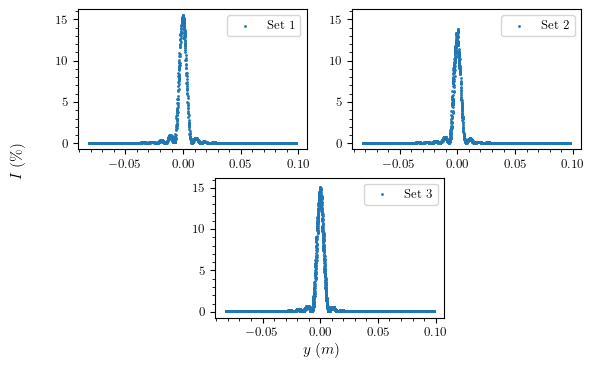

In [22]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 4, wspace=0.5)

axs = [
    fig.add_subplot(gs[0, :2]),
    fig.add_subplot(gs[0, 2:]),
    fig.add_subplot(gs[1, 1:3]),
]

for ax in axs:
    ax.sharex(axs[0])
    ax.sharey(axs[0])

for i, df in enumerate(dfs):
    axs[i].scatter(df.y, df.I, s=1, label=f"Set {i+1}")
    axs[i].legend()

fig.supxlabel(r"$y \; (m)$", size=mpl.rcParams['axes.labelsize'])
fig.supylabel(r"$I \; (\%)$", size=mpl.rcParams['axes.labelsize'])

fig.savefig(graph_path / f"single_scatter_{slit_name}.png")

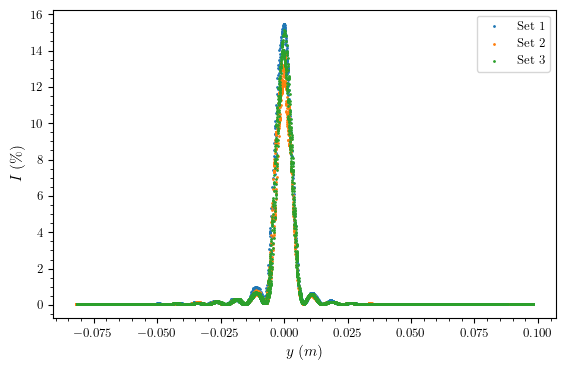

In [6]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"scatter_{slit_name}.png")

Find minimums

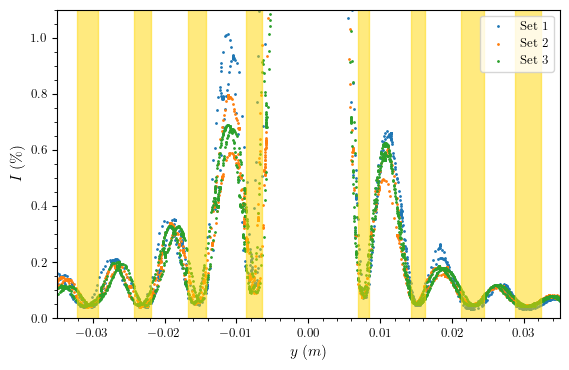

In [7]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

mins_left  = [-0.0322, -0.0243, -0.0168, -0.0087, 0.0069, 0.0143, 0.0213, 0.0287]
mins_right = [-0.0293, -0.0219, -0.0143, -0.0065, 0.0084, 0.0162, 0.0244, 0.0324]

for left, right in zip(mins_left, mins_right):
    ax.fill_betweenx(ylim, [left]*2, [right]*2, color="gold", alpha=0.5)

ax.set_ylim(0, 1.1)
ax.set_xlim(-0.035, 0.035)

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"min_{slit_name}.png")

Fenditura dai minimi

In [8]:
mins_df = pd.DataFrame()

mins_df['y'] = [
    (right + left) / 2
    for left, right in zip(mins_left, mins_right)
]
mins_df['dy'] = [
    abs(right - left) / 2
    for left, right in zip(mins_left, mins_right)
]

half_len = len(mins_df.index) / 2

mins_df['m'] = np.hstack([
    np.arange(-half_len, 0, dtype=np.int8),
    np.arange(1, half_len + 1, dtype=np.int8),
])

mins_df['l'] = mins_df.y / mins_df.m
mins_df['dl'] = abs(mins_df.dy / mins_df.m)

mins_df['a'] =  mins_df.apply(lambda r: wave_length * distance / r.l, axis=1)
mins_df['da'] =  mins_df.apply(lambda r: r.dl / r.l * r.a, axis=1)
mins_df['w'] = mins_df.da.to_numpy()**-2

print(
    np.average(mins_df.a, weights=mins_df.w),
    1 / np.sqrt(np.sum(mins_df.w))
)

mins_df

8.348461831531861e-05 1.9282693170610006e-06


,y,dy,m,l,dl,a,da,w
0,-0.03075,0.00145,-4,0.007687,0.000362,0.000083,0.000004,6.483736e+10
1,-0.02310,0.00120,-3,0.007700,0.000400,0.000083,0.000004,5.359740e+10
2,-0.01555,0.00125,-2,0.007775,0.000625,0.000082,0.000007,2.282141e+10
3,-0.00760,0.00110,-1,0.007600,0.001100,0.000084,0.000012,6.726201e+09
4,0.00765,0.00075,1,0.007650,0.000750,0.000084,0.000008,1.485334e+10
5,0.01525,0.00095,2,0.007625,0.000475,0.000084,0.000005,3.654879e+10
6,0.02285,0.00155,3,0.007617,0.000517,0.000084,0.000006,3.075670e+10
7,0.03055,0.00185,4,0.007638,0.000462,0.000084,0.000005,3.880451e+10


Salva tabella degli a

In [9]:
mins_df_str = pd.concat([
    mins_df.m,
    lab_round.measure_series(mins_df.y, mins_df.dy),
    lab_round.measure_series(mins_df.a * 10**3, mins_df.da * 10**3),
], axis='columns')

mins_df_str.to_latex(
    table_path / f"mins_{slit_name}.tex",
    columns=['m', 'y', 'a'],
    header=[
        r"$m$",
        r"$y \; (\si{\m})$",
        r"$a \; (\si{\mm})$"
    ],
    column_format='cc|c',
    index=False,
    escape=False,
)

mins_df_str

C:\Users\mrmat\AppData\Local\Temp\ipykernel_9480\2495423463.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  mins_df_str.to_latex(


,m,y,a
0,-4,\num{-0.0307+-0.0014},\num{0.083+-0.004}
1,-3,\num{-0.0231+-0.0012},\num{0.083+-0.004}
2,-2,\num{-0.0155+-0.0012},\num{0.082+-0.007}
3,-1,\num{-0.0076+-0.0011},\num{0.084+-0.012}
4,1,\num{0.0076+-0.0007},\num{0.084+-0.008}
5,2,\num{0.0152+-0.0009},\num{0.084+-0.005}
6,3,\num{0.0229+-0.0016},\num{0.084+-0.006}
7,4,\num{0.0306+-0.0018},\num{0.084+-0.005}


Fit

In [10]:
I_expr = s('I_0') * sp.Pow( sp.sinc(
    sp.pi * s('a') / s(r'\lambda') * s('y')/s('L')
), 2) + s('c')

I_fit = sp.lambdify(
    [s('y'), s('I_0'), s('a'), s('c')],
    I_expr.evalf(
        subs = {
            s(r'\lambda'): wave_length,
            s('L'): distance,
        }
    )
)

I_expr

I_0*sinc(pi*a*y/(L*\lambda))**2 + c

Rumore e picco

In [11]:
I_max = 1
I_min = 1

for df in dfs:
    I_min = df.I.min() if df.I.min() < I_min else I_min
    I_max = df.I.max() if df.I.max() > I_max else I_max

I_max, I_min

(15.47966003, 0.03265381)

In [12]:
I_fitted, a_fitted, c_fitted = 0, 0, 0
for df in dfs:
    popt, pcov = curve_fit(I_fit, df.y, df.I, [I_max, slit, I_min])
    print(popt)
    I_fitted += popt[0]
    a_fitted += popt[1]
    c_fitted += popt[2]

I_fitted /= len(dfs)
a_fitted /= len(dfs)
c_fitted /= len(dfs)

print(I_fitted)
print(a_fitted)
print(c_fitted)

[1.49764346e+01 7.89006844e-05 3.59030420e-02]
[1.25869828e+01 8.07645522e-05 4.32977455e-02]
[1.39608414e+01 8.36528575e-05 3.62137052e-02]
13.841419575732745
8.110603136018248e-05
0.038471497566317486


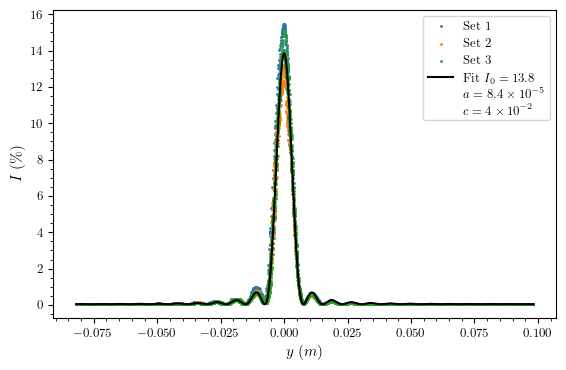

In [13]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

x = np.linspace(
    min([
        df.y.min()
        for df in dfs
    ]),
    max([
        df.y.max()
        for df in dfs
    ]),
    1000
)

ax.plot(x, I_fit(x, 13.8, 8.4e-5, 4e-2), color="black", label=r"Fit $I_0 = 13.8$ \par $a = 8.4 \times 10^{-5}$ \par $c = 4 \times 10^{-2}$")
# ax.plot(x, I_fit(x, I_fitted, a_fitted + 0.3e-5, c_fitted + 0.01))
# ax.plot(x, I_fit(x, I_fitted + 1.6, a_fitted - 0.4e-5, c_fitted + 0.012))
# ax.plot(x, I_fit(x, I_fitted - 1.6, a_fitted + 1e-5, c_fitted - 0.012))

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()


fig.savefig(graph_path / f"fit_{slit_name}.png")

Scegli il miglior set a 1.5

In [14]:
df_15 = dfs[0]

df_10 = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(1.0) in file
][0]

df_05 = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(0.5) in file
][0]

df_10.y += 0.0975
df_05.y += 0.098

Centrare i nuovi set

(-0.3053451575, 6.8825546275)

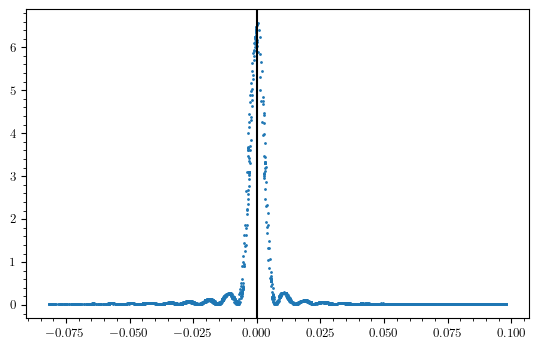

In [15]:
fig, ax = plt.subplots(1, 1)

df = df_05
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Confronto sensori

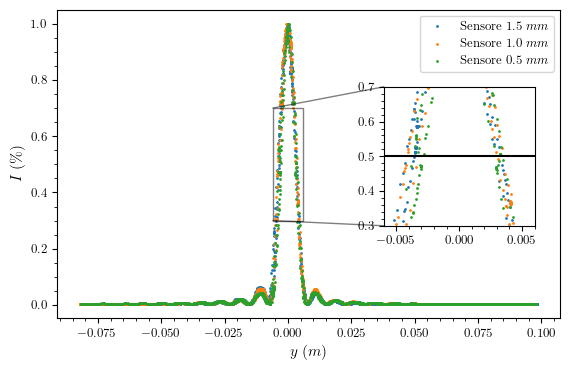

In [16]:
fig, ax = plt.subplots(1, 1)

ax.scatter(df_15.y, df_15.I / df_15.I.max(), s=1, label=r"Sensore $1.5 \; mm$")
ax.scatter(df_10.y, df_10.I / df_10.I.max(), s=1, label=r"Sensore $1.0 \; mm$")
ax.scatter(df_05.y, df_05.I / df_05.I.max(), s=1, label=r"Sensore $0.5 \; mm$")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

zoom = ax.inset_axes([0.65, 0.3, 0.3, 0.45])

zoom.scatter(df_15.y, df_15.I / df_15.I.max(), s=1, label=r"Sensore $1.5 \; mm$")
zoom.scatter(df_10.y, df_10.I / df_10.I.max(), s=1, label=r"Sensore $1.0 \; mm$")
zoom.scatter(df_05.y, df_05.I / df_05.I.max(), s=1, label=r"Sensore $0.5 \; mm$")

xlim = zoom.get_xlim()
zoom.plot(xlim, [0.5, 0.5], color="black")

zoom.set_xlim(-0.006, 0.006)
zoom.set_ylim(0.3, 0.7)

ax.indicate_inset_zoom(zoom, edgecolor="black")

fig.savefig(graph_path / f"sensor_{slit_name}.png")